<a href="https://colab.research.google.com/github/DrigoDomingos/GrowFrustratingRate/blob/master/grow_fr_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Are the customer geeting frustrated to not find a scooter near?
## The goal for this model giving a day of week and the hour what's is the most probable place where the customer will need a scooter and wont find it.

 

Author: Rodrigo Domingos dos Santos

Data source: Grow micro mobility company data sample for interview 

## Library setup

In [0]:
!pip install qgrid
!pip install pandas_ml

## Data Extraction (ELT)

In [0]:
import pandas_profiling
import numpy as np
import psycopg2
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd


from IPython.display import display
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from plotly import figure_factory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from plotly.graph_objs import Scatter, Figure, Layout
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [0]:
#connecting to Grow database

try:
   connection = psycopg2.connect(user="grin_technical_challenge",
                                  password="kjbaskc24bkjhb354bbjk",
                                  host="grin-technical-test.crf3v8rvj0hp.us-east-1.rds.amazonaws.com",
                                  port="5432",
                                  database="postgres")
    
   cursor = connection.cursor()
  
   postgreSQL_select_Query = "select * from rides"
   cursor.execute(postgreSQL_select_Query)
   print("Selecting rows from rides table using cursor.fetchall")
   db_rides = cursor.fetchall() 
  
   postgreSQL_select_Query = "select * from open_app "
   cursor.execute(postgreSQL_select_Query)
   print("Selecting rows from open_app table using cursor.fetchall")
   db_open_app = cursor.fetchall() 
   
   
except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

finally:
    #closing database connection.
    if(connection):
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

Selecting rows from rides table using cursor.fetchall
Selecting rows from open_app table using cursor.fetchall
PostgreSQL connection is closed


In [0]:
# Preparing Rides and Open_app dataframes
rides = pd.DataFrame(db_rides)
open_app = pd.DataFrame(db_open_app)

del db_open_app
del db_rides

In [0]:
#checking datasets
print("Open_app count: ", open_app.shape[0])
print("Rides count: ", rides.shape[0])

Open_app count:  4045654
Rides count:  2684712


In [0]:
open_app.columns = ['open_app_id','open_app_open_time','open_app_starting_lng','open_app_starting_lat','open_app_user_id']
open_app.head(10)

,open_app_id,open_app_open_time,open_app_starting_lng,open_app_starting_lat,open_app_user_id
0,5752835,2018-09-06 18:50:38.849992,-46.620773,-23.577507,367448.0
1,5760368,2018-09-06 19:27:04.918149,-46.664137,-23.510236,2417.0
2,5796007,2018-09-06 22:44:14.459921,-46.513518,-23.594870,1246871.0
3,5835624,2018-09-07 02:42:00.622821,-46.644312,-23.558633,122331.0
4,5845119,2018-09-07 03:36:43.836301,-46.528259,-23.467458,998959.0
5,5894699,2018-09-07 07:40:27.820390,-46.640090,-23.646100,660162.0
6,5923305,2018-09-07 10:21:18.709183,-46.490023,-23.430490,231899.0
7,5978291,2018-09-07 22:53:00.498650,-46.626569,-23.563210,122355.0
8,5984041,2018-09-07 23:41:27.174754,-46.590996,-23.689822,1195640.0
9,6117631,2018-09-08 19:45:53.066185,-46.695889,-23.660167,77356.0


In [0]:
rides.columns = ['id','open_app_id','rides_start_time','rides_finish_time','rides_starting_lng','rides_starting_lat','rides_dest_lng','rides_dest_lat','rides_price','rides_user_id','rides_scooter_id']
rides.head(10)

,id,open_app_id,rides_start_time,rides_finish_time,rides_starting_lng,rides_starting_lat,rides_dest_lng,rides_dest_lat,rides_price,rides_user_id,rides_scooter_id
0,1162485,5384922,2018-09-04 08:47:43.572471,2018-09-04 09:00:14.572471,-46.679033,-23.754911,-46.685941,-23.764152,7.19,620359.0,43599
1,1162486,5385395,2018-09-04 08:28:33.887084,2018-09-04 08:49:24.887084,-46.648738,-23.569628,-46.682250,-23.590317,11.43,161101.0,37340
2,1162487,5400441,2018-09-04 10:01:29.102877,2018-09-04 10:25:41.102877,-46.672856,-23.600067,-46.680993,-23.587127,8.06,549963.0,46595
3,1162488,5402180,2018-09-04 10:19:53.133126,2018-09-04 10:40:34.133126,-46.843795,-23.544592,-46.812068,-23.550125,9.20,661852.0,73903
4,1162489,5427154,2018-09-04 12:59:01.496354,2018-09-04 13:13:05.496354,-46.828576,-23.541941,-46.833309,-23.523381,8.45,829209.0,77763
5,1162490,5428052,2018-09-04 12:34:38.060571,2018-09-04 12:56:26.060571,-46.480771,-23.488976,-46.475705,-23.495810,7.13,848433.0,104724
6,1162491,5430046,2018-09-04 12:36:48.835668,2018-09-04 13:06:14.835668,-46.647905,-23.482009,-46.694438,-23.490647,15.70,1032002.0,14262
7,1162492,5454407,2018-09-04 14:56:30.986169,2018-09-04 15:09:51.986169,-46.602735,-23.645894,-46.593796,-23.653477,12.14,766625.0,33052
8,1162493,5472023,2018-09-04 16:44:19.005497,2018-09-04 17:20:07.005497,-46.550919,-23.622113,-46.596954,-23.614995,19.12,1111342.0,28789
9,1162494,5506022,2018-09-04 20:08:48.420754,2018-09-04 20:54:45.420754,-46.683973,-23.526180,-46.715140,-23.600041,29.50,292565.0,94550


In [0]:
#Merging datasets using full outer join
df = pd.merge(open_app, rides, on='open_app_id', how='outer')
df.shape[0]

4045654


## Machine Learning data preparation


In [0]:
#Feature engineering

dfml = df[['open_app_id','open_app_open_time','open_app_starting_lng','open_app_starting_lat','id']]

dfml['day0fweek'] = dfml['open_app_open_time'].dt.dayofweek
dfml['hour'] =  dfml['open_app_open_time'].dt.hour
dfml['long'] = dfml['open_app_starting_lng'].apply(lambda x: round(x, 3))
dfml['lat'] = dfml['open_app_starting_lat'].apply(lambda x: round(x, 3))
dfml['result'] = dfml['id']
dfml['result'].fillna(0, inplace = True)
dfml['result'] = np.where(dfml['result']==0, 0, 1)
dfml.describe()

del df


### Highlight: Customer Frustration rate

In [0]:
#Checking the frequency
# 1 Opened the app and started a ride
# 0 Opned the app and not started a ride
print(dfml['result'].value_counts())
print('Customer frustration rate: ', dfml[dfml['result'] == 0].result.count() / dfml['result'].count())

1    2684712
0    1360942
Name: result, dtype: int64
Customer frustration rate:  0.3363960437546068


## The first hypothesis is that: if the customer opens the app and not start a ride it's because there's no scooter available in an acceptable distance.

In [0]:
#summarizing dataset
dfml_hist = dfml[['open_app_open_time','result']]
dfml_hist.open_app_open_time = dfml.open_app_open_time.astype(str).str.slice(0, 10)

dfml_hist_wr = dfml_hist[dfml_hist['result'] == 1]


dfml_hist = dfml_hist.groupby(['open_app_open_time']).size().reset_index(name='Total_Count')

dfml_hist_wr = dfml_hist_wr.groupby(['open_app_open_time']).size().reset_index(name='With_Ride')

dfml_hist = pd.merge(dfml_hist, dfml_hist_wr, on='open_app_open_time', how='left')

#Exporting CSV to perform data analysis

dfml_hist.to_csv('tbl_grow_rodrigo_perf_hist.csv', sep='|', encoding='utf-8',index=False)


In [0]:
#Selecting usefull columns
columns = ['open_app_id','open_app_open_time','open_app_starting_lng','open_app_starting_lat','id']
dfml.drop(columns, inplace=True, axis=1)
dfml.head()

,day0fweek,hour,long,lat,result
0,3,18,-46.621,-23.578,0
1,3,19,-46.664,-23.510,0
2,3,22,-46.514,-23.595,0
3,4,2,-46.644,-23.559,0
4,4,3,-46.528,-23.467,0


## Data visualization

In [0]:
#General data visualization analisys
pandas_profiling.ProfileReport(dfml)

Number of variables,5
Number of observations,4045654
Total Missing (%),0.0%
Total size in memory,185.2 MiB
Average record size in memory,48.0 B
Numeric,4
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


## Machine Learning trainning

In [0]:
#Training and test data
#Using basic 80-20 split on this first version, planning to use kfold on v2

y = dfml[['result']]
dfml.drop('result',inplace=True, axis=1)

# Data Split
X_train, X_test, y_train, y_test = train_test_split(dfml, y, test_size=0.2, random_state=42)

print(dfml.head())

# Sparse Matrix
d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_test, y_test)




   day0fweek  hour    long     lat
0          3    18 -46.621 -23.578
1          3    19 -46.664 -23.510
2          3    22 -46.514 -23.595
3          4     2 -46.644 -23.559
4          4     3 -46.528 -23.467


In [0]:
# Parameters
#Using default parameters this first version, planning to grid search on v2

xgb_params = {'eta': 0.2
             ,'gamma': 0
             ,'min_child_weight':1
             ,'max_delta_step':0
             ,'subsample':1
             ,'colsample_bytree ':1
             ,'colsample_bylevel':1
             ,'lambda': 1
             ,'alpha':1
             ,'scale_pos_weight':1         
             ,'max_depth': 6
             ,'objective': 'binary:logistic'
             ,'eval_metric': 'logloss'
             ,'seed': 99
             ,'silent': True}      
# Model trainig
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model = xgb.train(xgb_params 
                  ,d_train, 1000
                  ,watchlist
                  ,maximize=False
                  ,verbose_eval=5
                  ,early_stopping_rounds=50)

[0]	train-logloss:0.637277	valid-logloss:0.637186
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[5]	train-logloss:0.535554	valid-logloss:0.535239
[10]	train-logloss:0.515242	valid-logloss:0.514916
[15]	train-logloss:0.509642	valid-logloss:0.509355
[20]	train-logloss:0.506736	valid-logloss:0.506524
[25]	train-logloss:0.504447	valid-logloss:0.504312
[30]	train-logloss:0.503451	valid-logloss:0.503384
[35]	train-logloss:0.502787	valid-logloss:0.502803
[40]	train-logloss:0.50201	valid-logloss:0.502083
[45]	train-logloss:0.500926	valid-logloss:0.501044
[50]	train-logloss:0.500234	valid-logloss:0.500412
[55]	train-logloss:0.499873	valid-logloss:0.50012
[60]	train-logloss:0.499192	valid-logloss:0.499491
[65]	train-logloss:0.498489	valid-logloss:0.498833
[70]	train-logloss:0.497847	valid-logloss:0.498235
[75]	train-logloss:0.497636	valid-logloss:0.498075
[80]	train-logloss:0.497382	valid-log

# Machine Learning results

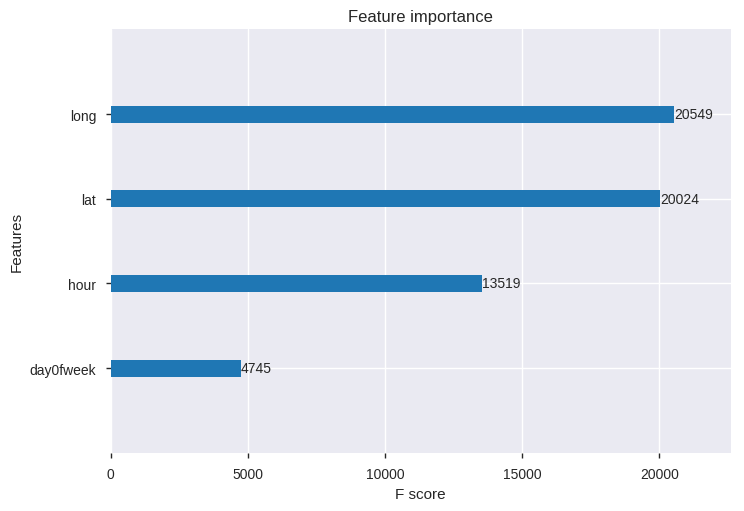

In [0]:
#Plotting feature importance
xgb.plot_importance(model)

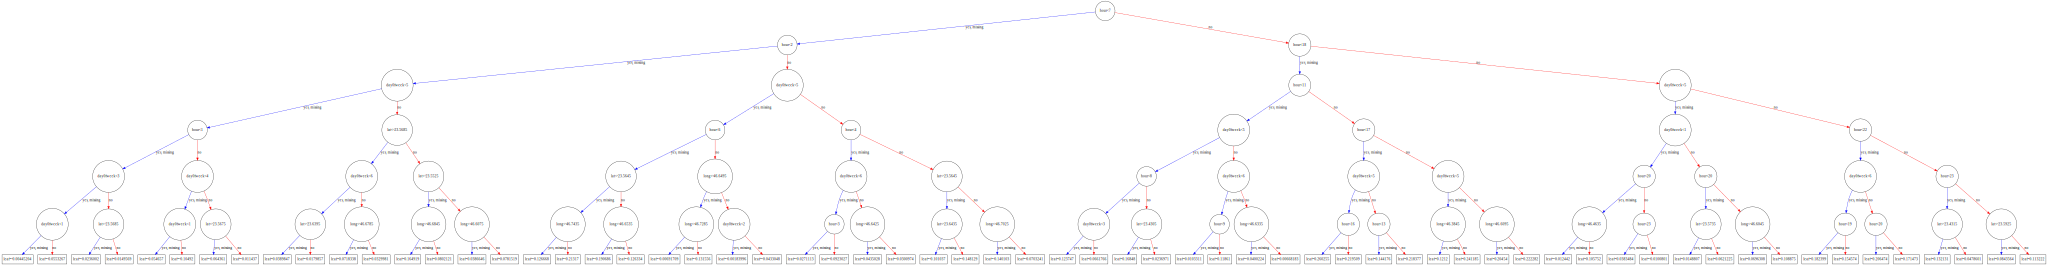

In [0]:
#Plotting model tree
xgb.to_graphviz(model, num_trees=2)

In [0]:
#Saving the model
model.save_model('grow_frustration_v1.model')

In [0]:
#Loading the model
model = xgb.Booster({'nthread': 4})  # init model
model.load_model('grow_frustration_v1.model')  # load data

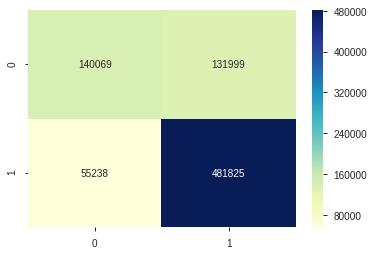

In [0]:
#Checking results using confusion matrix
%matplotlib inline
model_pred = model.predict(d_valid)
cm=confusion_matrix(y_test, model_pred.round()) 
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), linewidths=0, cmap="YlGnBu",annot=True,ax = ax,fmt='g')
# labels, title and ticks
ax.figsize=(15,8)## Validação


## Machine Learning prediction
### Select the day of week and the hour that you want to predict:

In [0]:
#@title Prediction form { display-mode: "form" }
Day_of_week_to_predict = 4 #@param {type:"slider", min:0, max:6, step:1}
hour_to_predict = 12 #@param {type:"slider", min:0, max:24, step:1}


dfpred = pd.DataFrame(np.unique(dfml[['long','lat']], axis=0))
dfpred.columns = ['long','lat']

dfpred['day0fweek'] = Day_of_week_to_predict
dfpred['hour'] = hour_to_predict

dfpred = dfpred[['day0fweek','hour','long','lat']]


dfpred.head()




,day0fweek,hour,long,lat
0,4,12,-47.069,-23.937
1,4,12,-47.054,-23.657
2,4,12,-47.049,-23.656
3,4,12,-47.046,-23.665
4,4,12,-47.033,-23.682


In [0]:
#Performing prediction

d_predic = xgb.DMatrix(dfpred)

dfpred['prediction_perc'] = model.predict(d_predic)
dfpred['prediction']  = model.predict(d_predic).round() 
dfpred.head(10)


,day0fweek,hour,long,lat,prediction_perc,prediction
0,4,12,-47.069,-23.937,0.999273,1.0
1,4,12,-47.054,-23.657,0.958027,1.0
2,4,12,-47.049,-23.656,0.938404,1.0
3,4,12,-47.046,-23.665,0.981378,1.0
4,4,12,-47.033,-23.682,0.997434,1.0
5,4,12,-47.030,-23.680,0.994982,1.0
6,4,12,-47.030,-23.607,0.993345,1.0
7,4,12,-47.030,-23.605,0.994790,1.0
8,4,12,-47.027,-23.606,0.993095,1.0
9,4,12,-47.027,-23.605,0.994790,1.0


In [0]:
#Showing prediction frequency
dfpred['prediction'].value_counts()

1.0    124022
0.0        44
Name: prediction, dtype: int64

## Exporting result
### ! Please uncomment to overwrite the previous result

In [0]:
#Exporting results to CSV
dfpred.to_csv('tbl_grow_rodrigo_frate.csv', sep='|', encoding='utf-8',index=False)
 

## The Dashboard built based on the output information:

Dashboard
https://public.tableau.com/profile/rodrigo3750#!/vizhome/GrowFrustrationRate/RideSearchFrustration  

Story
https://public.tableau.com/profile/rodrigo3750#!/vizhome/GrowFrustrationRatepresentation/FRatePresentation